# Prep Data

Create a data table showing voter turnout rate by county for the 2016 Presidential election

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sns.set_style("darkgrid", rc=custom_style)

## Total Votes by county

The data was scraped from https://www.townhall.com/election/2016/president/  

Found a github repo where much of this scraping has been done already: https://github.com/tonmcg/US_County_Level_Election_Results_08-16

In [3]:
file_url = 'https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/2016_US_County_Level_Presidential_Results.csv'
votes_df = pd.read_csv(file_url)

In [4]:
votes_df.head()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060


In [5]:
votes_df = votes_df[['total_votes', 'state_abbr', 'county_name', 'combined_fips']]

In [6]:
votes_df.rename(columns={'total_votes': 'totalVotes', 'combined_fips': 'FIPS'}, inplace=True)

In [7]:
votes_df['FIPS'] = votes_df['FIPS'].apply(lambda x: str(x).zfill(5))

In [8]:
votes_df.tail()

,totalVotes,state_abbr,county_name,FIPS
3136,16661.0,WY,Sweetwater County,56037
3137,12176.0,WY,Teton County,56039
3138,8053.0,WY,Uinta County,56041
3139,3715.0,WY,Washakie County,56043
3140,3334.0,WY,Weston County,56045


In [9]:
votes_df.shape

(3141, 4)

# Voting Age Population by county

County level data from US Census, 2012-2016 American Community Survey 5 year estimates https://www.census.gov/programs-surveys/decennial-census/about/voting-rights/cvap.2016.html

**Note:** had to download, and resave the County.csv file with encoding as utf-8 

In [10]:
ls data/raw

ACS_CVAP_County.csv  usCounties.csv


In [11]:
vap_df = pd.read_csv('data/raw/ACS_CVAP_County.csv')

In [12]:
vap_df.head()

,GEONAME,LNTITLE,GEOID,LNNUMBER,TOT_EST,TOT_MOE,ADU_EST,ADU_MOE,CIT_EST,CIT_MOE,CVAP_EST,CVAP_MOE
0,"Autauga County, Alabama",Total,05000US01001,1,55050,NaN,41195,34.0,54510,263,40690,236
1,"Autauga County, Alabama",Not Hispanic or Latino,05000US01001,2,53635,NaN,40290,35.0,53325,220,40015,184
2,"Autauga County, Alabama",American Indian or Alaska Native Alone,05000US01001,3,225,74.0,125,55.0,225,74,125,55
3,"Autauga County, Alabama",Asian Alone,05000US01001,4,485,165.0,390,106.0,340,200,245,161
4,"Autauga County, Alabama",Black or African American Alone,05000US01001,5,10115,242.0,7470,75.0,10115,242,7470,75


We want only the **TOTAL** rows

In [13]:
vap_df = vap_df[vap_df['LNNUMBER'] == 1]  # LNNUMBER = 1 is code for LNTITLE = Total

In [14]:
vap_df.shape

(3220, 12)

In [15]:
vap_df = vap_df[['GEONAME', 'GEOID', 'CVAP_EST', 'CVAP_MOE']]

In [16]:
vap_df.rename(
    columns = {
        'GEOID': 'FIPS',
        'CVAP_EST': 'VAP', 
        'CVAP_MOE':'VAP_MOE'}, 
    inplace=True)


In [17]:
vap_df['FIPS'] = vap_df['FIPS'].apply(lambda x: x[-5:])

In [18]:
vap_df['STATE'] = vap_df['GEONAME'].apply(lambda x: x.split(',')[1])

In [19]:
vap_df

,GEONAME,FIPS,VAP,VAP_MOE,STATE
0,"Autauga County, Alabama",01001,40690,236,Alabama
13,"Baldwin County, Alabama",01003,151770,680,Alabama
26,"Barbour County, Alabama",01005,20375,113,Alabama
39,"Bibb County, Alabama",01007,17590,81,Alabama
52,"Blount County, Alabama",01009,42430,314,Alabama
...,...,...,...,...,...
41795,"Vega Baja Municipio, Puerto Rico",72145,43335,90,Puerto Rico
41808,"Vieques Municipio, Puerto Rico",72147,7075,16,Puerto Rico
41821,"Villalba Municipio, Puerto Rico",72149,18270,52,Puerto Rico
41834,"Yabucoa Municipio, Puerto Rico",72151,27785,44,Puerto Rico


# Master list of all Counties

In [20]:
counties_df = pd.read_csv('data/raw/usCounties.csv')

In [21]:
counties_df.head()

,stateAbbrev,stateFIPS,countyFIPS,countyName,huh
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


In [22]:
def combineFIPS(row):
    state = str(row['stateFIPS']).zfill(2)
    county = str(row['countyFIPS']).zfill(3)
    
    return '{}{}'.format(state,county)

In [23]:
counties_df['FIPS'] = counties_df.apply(combineFIPS, axis=1)

In [24]:
counties_df = counties_df[['stateAbbrev', 'countyName', 'FIPS']]

In [25]:
counties_df.head()

,stateAbbrev,countyName,FIPS
0,AL,Autauga County,01001
1,AL,Baldwin County,01003
2,AL,Barbour County,01005
3,AL,Bibb County,01007
4,AL,Blount County,01009


In [26]:
counties_df.shape

(3235, 3)

# Combine

combined the vote tallies and vap for each county in the master county list

### total votes

In [27]:
df = counties_df.merge(votes_df[['totalVotes', 'FIPS']], how='left', on='FIPS')

In [28]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes
0,AL,Autauga County,01001,24661.0
1,AL,Baldwin County,01003,94090.0
2,AL,Barbour County,01005,10390.0
3,AL,Bibb County,01007,8748.0
4,AL,Blount County,01009,25384.0


In [29]:
df['totalVotes'].isnull().sum()

94

In [30]:
df.dropna(inplace=True)

## VAP

In [31]:
df = df.merge(vap_df[['VAP', 'STATE', 'FIPS']], how='left', on='FIPS')

In [32]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,STATE
0,AL,Autauga County,01001,24661.0,40690.0,Alabama
1,AL,Baldwin County,01003,94090.0,151770.0,Alabama
2,AL,Barbour County,01005,10390.0,20375.0,Alabama
3,AL,Bibb County,01007,8748.0,17590.0,Alabama
4,AL,Blount County,01009,25384.0,42430.0,Alabama


In [33]:
df['VAP'].isnull().sum()

2

# Clean up Alaska. Alaska reports at the state and precint level, not county. Use same value for every county in Alaska

In [34]:
np.nan/43

nan

# Calculate Voter Turnout Rates

In [35]:
totalVAP_AK = df[df['stateAbbrev'] == 'AK']['VAP'].sum()
df.loc[df['stateAbbrev'] == 'AK', 'VAP']= totalVAP_AK

In [36]:
def turnout(row):
    votes = row['totalVotes']
    vap = row['VAP']
    
    return votes/vap * 100

In [37]:
df['turnoutPerc'] = df.apply(turnout, axis=1)

In [38]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,STATE,turnoutPerc
0,AL,Autauga County,01001,24661.0,40690.0,Alabama,60.607029
1,AL,Baldwin County,01003,94090.0,151770.0,Alabama,61.995124
2,AL,Barbour County,01005,10390.0,20375.0,Alabama,50.993865
3,AL,Bibb County,01007,8748.0,17590.0,Alabama,49.732803
4,AL,Blount County,01009,25384.0,42430.0,Alabama,59.825595


In [39]:
# calculate non voters
df['nNonVote'] = df['VAP'] - df['totalVotes']

In [40]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,STATE,turnoutPerc,nNonVote
0,AL,Autauga County,01001,24661.0,40690.0,Alabama,60.607029,16029.0
1,AL,Baldwin County,01003,94090.0,151770.0,Alabama,61.995124,57680.0
2,AL,Barbour County,01005,10390.0,20375.0,Alabama,50.993865,9985.0
3,AL,Bibb County,01007,8748.0,17590.0,Alabama,49.732803,8842.0
4,AL,Blount County,01009,25384.0,42430.0,Alabama,59.825595,17046.0


In [41]:
# clear out the anomalous numbers
df['turnoutPerc'] = df['turnoutPerc'].apply(lambda x: x if x < 100 else 100)
df['nNonVote'] = df['nNonVote'].apply(lambda x: x if x >= 0 else 0)

In [42]:
# calculate the percent different from the overall US mean (55.5% of VAP in 2016 (wikipedia))
df['percFromMean'] = df['turnoutPerc'] - 55.5

In [44]:
df['STATE'] = df['STATE'].apply(lambda x: str(x).strip())
df.rename(columns={'STATE': 'state'}, inplace=True)

# summary of data

<AxesSubplot:>

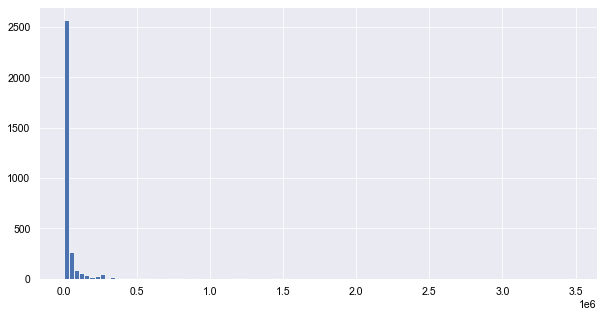

In [45]:
plt.figure(figsize=(10,5))
df['nNonVote'].hist(bins=100)

In [46]:
df['nNonVote'].max()

3471418.0

In [47]:
df.loc[df['nNonVote'].argmax()]

stateAbbrev                     CA
countyName      Los Angeles County
FIPS                         06037
totalVotes             2.65207e+06
VAP                    6.12349e+06
state                   California
turnoutPerc                43.3098
nNonVote               3.47142e+06
percFromMean              -12.1902
Name: 204, dtype: object

In [48]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,state,turnoutPerc,nNonVote,percFromMean
0,AL,Autauga County,01001,24661.0,40690.0,Alabama,60.607029,16029.0,5.107029
1,AL,Baldwin County,01003,94090.0,151770.0,Alabama,61.995124,57680.0,6.495124
2,AL,Barbour County,01005,10390.0,20375.0,Alabama,50.993865,9985.0,-4.506135
3,AL,Bibb County,01007,8748.0,17590.0,Alabama,49.732803,8842.0,-5.767197
4,AL,Blount County,01009,25384.0,42430.0,Alabama,59.825595,17046.0,4.325595


In [49]:
df[df['stateAbbrev'] == 'AK']

,stateAbbrev,countyName,FIPS,totalVotes,VAP,state,turnoutPerc,nNonVote,percFromMean
67,AK,Aleutians East Borough,02013,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
68,AK,Aleutians West Census Area,02016,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
69,AK,Anchorage Municipality,02020,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
70,AK,Bethel Census Area,02050,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
71,AK,Bristol Bay Borough,02060,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
72,AK,Denali Borough,02068,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
73,AK,Dillingham Census Area,02070,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
74,AK,Fairbanks North Star Borough,02090,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
75,AK,Haines Borough,02100,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806
76,AK,Hoonah-Angoon Census Area,02105,246588.0,523095.0,Alaska,47.140194,276507.0,-8.359806


# Write out data

In [50]:
df.shape

(3141, 9)

In [51]:
df.dropna(inplace=True)

In [52]:
df.shape

(3140, 9)

In [53]:
df.to_csv('data/voterTurnout.csv', index=False)

## misc

In [54]:
strLen = df['countyName'].apply(lambda x: len(x))

<AxesSubplot:>

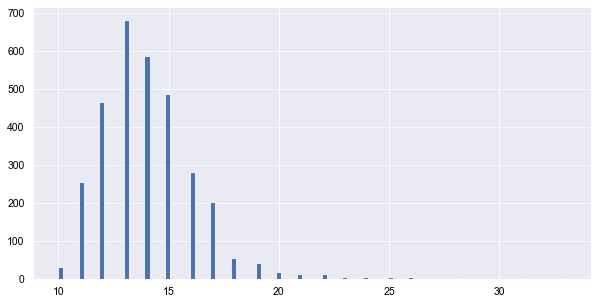

In [55]:
plt.figure(figsize=(10,5))
strLen.hist(bins=100)

In [56]:
strLen.max()

33

In [57]:
# county with the longest name
df.loc[strLen.argmax()]

stateAbbrev                                    AK
countyName      Prince of Wales-Hyder Census Area
FIPS                                        02198
totalVotes                                 246588
VAP                                        523095
state                                      Alaska
turnoutPerc                               47.1402
nNonVote                                   276507
percFromMean                             -8.35981
Name: 87, dtype: object

<AxesSubplot:>

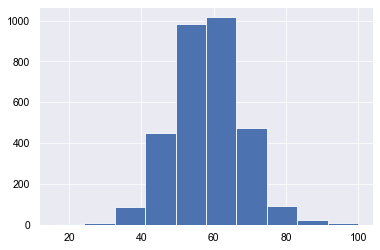

In [58]:
df['turnoutPerc'].hist()

In [59]:
df.query('turnoutPerc >= 99')

,stateAbbrev,countyName,FIPS,totalVotes,VAP,state,turnoutPerc,nNonVote,percFromMean
300,CO,San Juan County,08111,506.0,495.0,Colorado,100.00000,0.0,44.50000
1805,NM,Harding County,35021,527.0,470.0,New Mexico,100.00000,0.0,44.50000
2672,TX,Loving County,48301,64.0,60.0,Texas,100.00000,0.0,44.50000
2677,TX,McMullen County,48311,497.0,460.0,Texas,100.00000,0.0,44.50000
2708,TX,Polk County,48373,34444.0,34770.0,Texas,99.06241,326.0,43.56241


<AxesSubplot:>

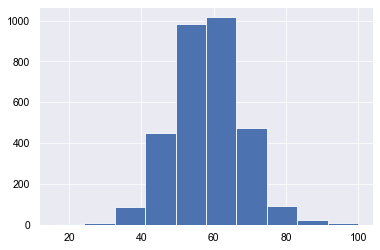

In [60]:
df['turnoutPerc'].hist()

In [61]:
df['turnoutPerc'].min()

15.790074158585282